# Stochastic Solver: Mixing stochastic and deterministic equations

Copyright (C) 2011 and later, Paul D. Nation & Robert J. Johansson

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, coherent, destroy, fock, general_stochastic, ket2dm,
                   liouvillian, mesolve, parallel_map, photocurrent_mesolve,
                   plot_expectation_values, smesolve, spost, spre)
from qutip.expect import expect_rho_vec
%matplotlib inline

rcParams["font.family"] = "STIXGeneral"
rcParams["mathtext.fontset"] = "stix"
rcParams["font.size"] = "14"

## Direct photo-detection

Here we follow an example from Wiseman and Milburn, *Quantum measurement and control*, section. 4.8.1.

Consider cavity that leaks photons with a rate $\kappa$. The dissipated photons are detected with an inefficient photon detector,
with photon-detection efficiency $\eta$. The master equation describing this scenario, where a separate dissipation channel has been added for detections and missed detections, is

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$

To describe the photon measurement stochastically, we can unravelling only the dissipation term that corresponds to detections, and leaving the missed detections as a deterministic dissipation term, we obtain [Eq. (4.235) in W&M]

$d\rho = \mathcal{H}[-iH -\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

or

$d\rho = -i[H, \rho] dt + \mathcal{D}[\sqrt{1-\eta} a] \rho dt -\mathcal{H}[\eta\frac{1}{2}a^\dagger a] \rho dt + \mathcal{G}[\sqrt{\eta}a] \rho dN(t)$

where

$\displaystyle \mathcal{G}[A] \rho = \frac{A\rho A^\dagger}{\mathrm{Tr}[A\rho A^\dagger]} - \rho$

$\displaystyle \mathcal{H}[A] \rho = A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho $

and $dN(t)$ is a Poisson distributed increment with $E[dN(t)] = \eta \langle a^\dagger a\rangle (t)$.

### Formulation in QuTiP

In QuTiP, the photocurrent stochastic master equation is written in the form:

$\displaystyle d\rho(t) = -i[H, \rho] dt + \mathcal{D}[B] \rho dt - \frac{1}{2}\mathcal{H}[A^\dagger A]\rho(t) dt + \mathcal{G}[A]\rho(t) d\xi$

where the first two term gives the deterministic master equation (Lindblad form with collapse operator $B$ (c_ops)) and $A$ the stochastic collapse operator (sc_ops). 

Here $A = \sqrt{\eta\gamma}a $ and $B = \sqrt{(1-\eta)\gamma} a$


In [2]:
N = 15
w0 = 0.5 * 2 * np.pi
times = np.linspace(0, 15, 150)
dt = times[1] - times[0]
gamma = 0.1

a = destroy(N)

H = w0 * a.dag() * a

rho0 = fock(N, 5)

e_ops = [a.dag() * a, a + a.dag()]

### Highly efficient detection

In [3]:
eta = 0.7
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [4]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [5]:
result1 = photocurrent_mesolve(
    H,
    rho0,
    times,
    c_ops=c_ops,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=1,
    nsubsteps=100,
    store_measurement=True,
)

Total run time:   0.04s


In [6]:
result2 = photocurrent_mesolve(
    H,
    rho0,
    times,
    c_ops=c_ops,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=10,
    nsubsteps=100,
    store_measurement=True,
)

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00


20.0%. Run time:   0.08s. Est. time left: 00:00:00:00


30.0%. Run time:   0.13s. Est. time left: 00:00:00:00


40.0%. Run time:   0.17s. Est. time left: 00:00:00:00


50.0%. Run time:   0.21s. Est. time left: 00:00:00:00

60.0%. Run time:   0.26s. Est. time left: 00:00:00:00


70.0%. Run time:   0.30s. Est. time left: 00:00:00:00


80.0%. Run time:   0.34s. Est. time left: 00:00:00:00

90.0%. Run time:   0.38s. Est. time left: 00:00:00:00

Total run time:   0.43s


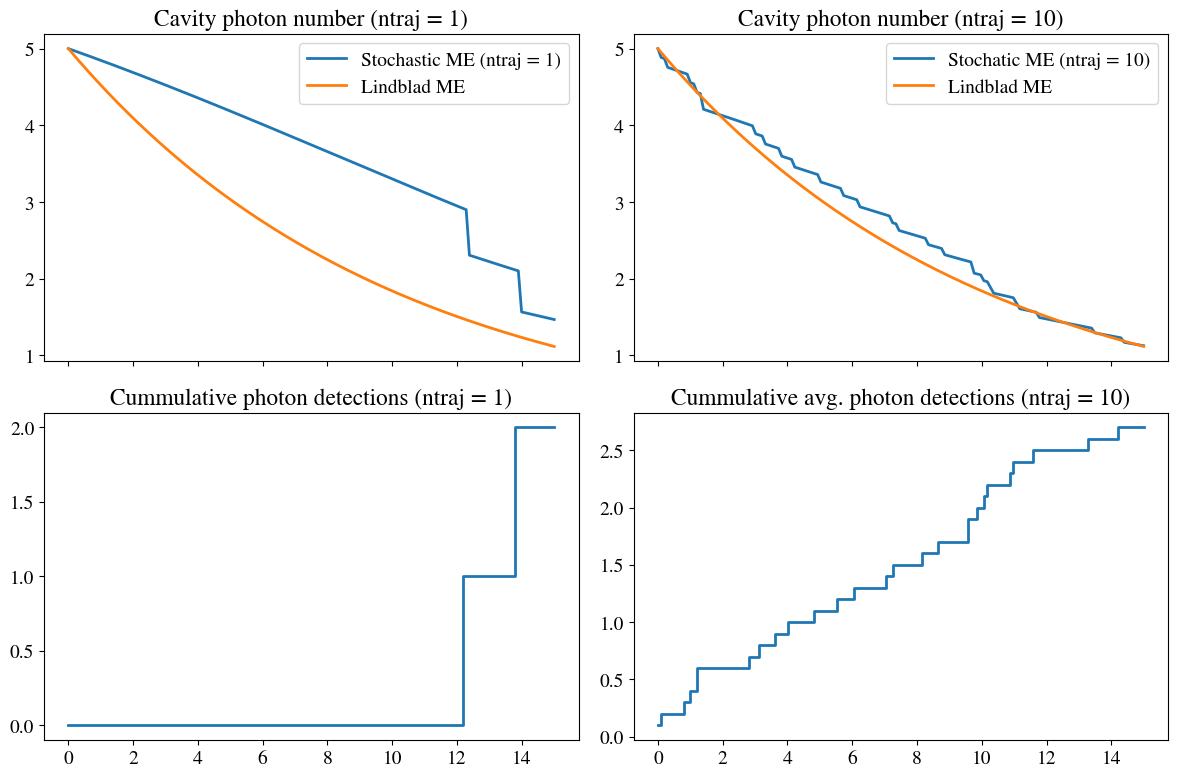

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axes[0, 0].plot(times, result1.expect[0],
                label=r"Stochastic ME (ntraj = 1)", lw=2)
axes[0, 0].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 0].set_title("Cavity photon number (ntraj = 1)")
axes[0, 0].legend()

axes[0, 1].plot(times, result2.expect[0],
                label=r"Stochatic ME (ntraj = 10)", lw=2)
axes[0, 1].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 1].set_title("Cavity photon number (ntraj = 10)")
axes[0, 1].legend()

axes[1, 0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1, 0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1, 1].step(
    times,
    dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10,
    lw=2
)
axes[1, 1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

### Highly inefficient photon detection

In [8]:
eta = 0.1
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [9]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [10]:
result1 = photocurrent_mesolve(
    H,
    rho0,
    times,
    c_ops=c_ops,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=1,
    nsubsteps=100,
    store_measurement=True,
)

Total run time:   0.04s


In [11]:
result2 = photocurrent_mesolve(
    H,
    rho0,
    times,
    c_ops=c_ops,
    sc_ops=sc_ops,
    e_ops=e_ops,
    ntraj=10,
    nsubsteps=100,
    store_measurement=True,
)

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00


20.0%. Run time:   0.08s. Est. time left: 00:00:00:00


30.0%. Run time:   0.13s. Est. time left: 00:00:00:00


40.0%. Run time:   0.17s. Est. time left: 00:00:00:00


50.0%. Run time:   0.21s. Est. time left: 00:00:00:00

60.0%. Run time:   0.25s. Est. time left: 00:00:00:00

70.0%. Run time:   0.29s. Est. time left: 00:00:00:00

80.0%. Run time:   0.34s. Est. time left: 00:00:00:00

90.0%. Run time:   0.38s. Est. time left: 00:00:00:00

Total run time:   0.42s

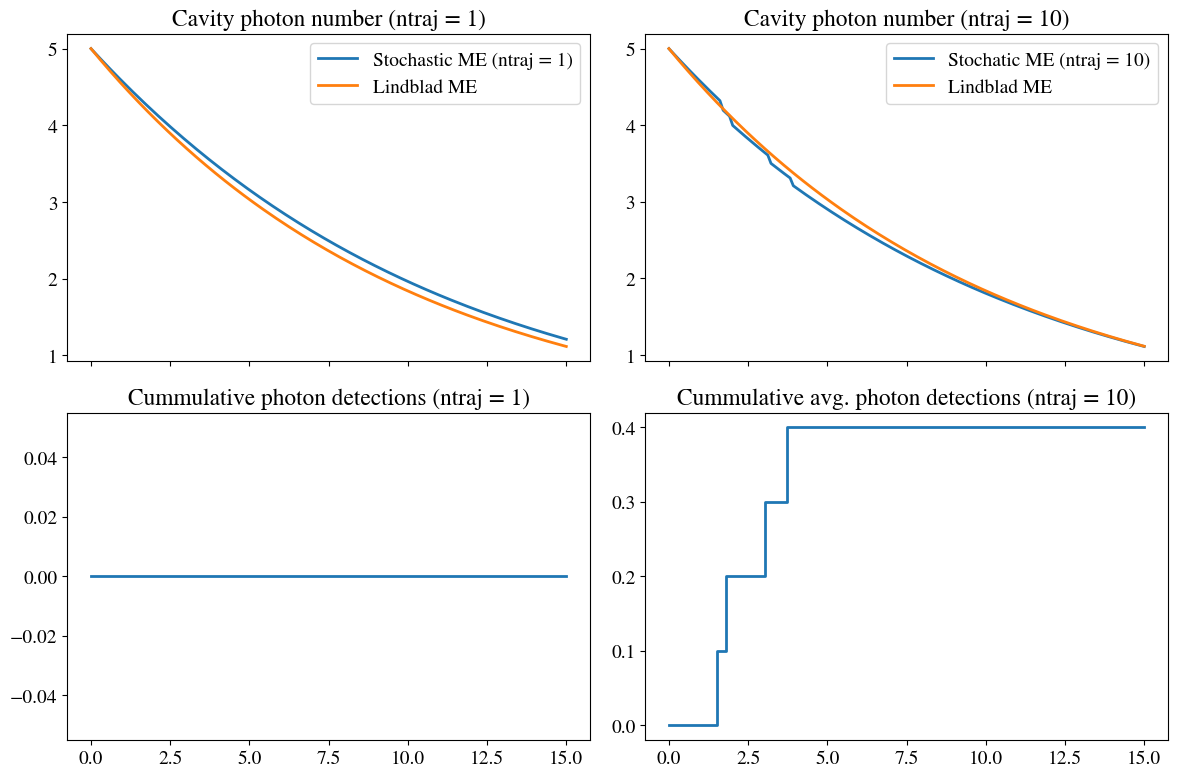

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

axes[0, 0].plot(times, result1.expect[0],
                label=r"Stochastic ME (ntraj = 1)", lw=2)
axes[0, 0].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 0].set_title("Cavity photon number (ntraj = 1)")
axes[0, 0].legend()

axes[0, 1].plot(times, result2.expect[0],
                label=r"Stochatic ME (ntraj = 10)", lw=2)
axes[0, 1].plot(times, result_ref.expect[0], label=r"Lindblad ME", lw=2)
axes[0, 1].set_title("Cavity photon number (ntraj = 10)")
axes[0, 1].legend()

axes[1, 0].step(times, dt * np.cumsum(result1.measurement[0].real), lw=2)
axes[1, 0].set_title("Cummulative photon detections (ntraj = 1)")
axes[1, 1].step(
    times,
    dt * np.cumsum(np.array(result2.measurement).sum(axis=0).real) / 10,
    lw=2
)
axes[1, 1].set_title("Cummulative avg. photon detections (ntraj = 10)")

fig.tight_layout()

## Efficient homodyne detection

The stochastic master equation for inefficient homodyne detection, when unravaling the detection part of the master equation

$\dot\rho = -i[H, \rho] + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] + \mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a]$,

is given in W&M as

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{1-\eta} \sqrt{\kappa} a] \rho dt 
+
\mathcal{D}[\sqrt{\eta} \sqrt{\kappa}a] \rho dt
+
\mathcal{H}[\sqrt{\eta} \sqrt{\kappa}a] \rho d\xi$

where $d\xi$ is the Wiener increment. This can be described as a standard homodyne detection with efficiency $\eta$ together with a stochastic dissipation process with collapse operator $\sqrt{(1-\eta)\kappa} a$. Alternatively we can combine the two deterministic terms on standard Lindblad for and obtain the stochastic equation (which is the form given in W&M)

$d\rho = -i[H, \rho]dt + \mathcal{D}[\sqrt{\kappa} a]\rho dt + \sqrt{\eta}\mathcal{H}[\sqrt{\kappa}a] \rho d\xi$

Below we solve these two equivalent equations with QuTiP

In [13]:
rho0 = coherent(N, np.sqrt(5))

### Form 1: Standard homodyne with deterministic dissipation on Lindblad form

In [14]:
eta = 0.95
c_ops = [np.sqrt(1 - eta) * np.sqrt(gamma) * a]  # collapse operator B
sc_ops = [np.sqrt(eta) * np.sqrt(gamma) * a]  # stochastic collapse operator A

In [15]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [16]:
result = smesolve(
    H,
    rho0,
    times,
    c_ops,
    sc_ops,
    e_ops,
    ntraj=75,
    nsubsteps=100,
    solver="platen",
    method="homodyne",
    store_measurement=True,
    map_func=parallel_map,
    noise=111,
)

10.7%. Run time:   0.49s. Est. time left: 00:00:00:04


20.0%. Run time:   0.95s. Est. time left: 00:00:00:03


30.7%. Run time:   1.41s. Est. time left: 00:00:00:03


40.0%. Run time:   1.86s. Est. time left: 00:00:00:02


50.7%. Run time:   2.31s. Est. time left: 00:00:00:02


60.0%. Run time:   2.77s. Est. time left: 00:00:00:01


70.7%. Run time:   3.22s. Est. time left: 00:00:00:01


80.0%. Run time:   3.47s. Est. time left: 00:00:00:00


90.7%. Run time:   3.93s. Est. time left: 00:00:00:00


100.0%. Run time:   4.34s. Est. time left: 00:00:00:00


Total run time:   4.35s


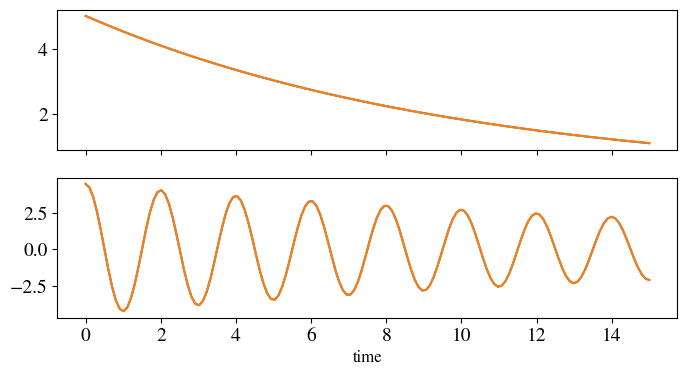

In [17]:
plot_expectation_values([result, result_ref]);

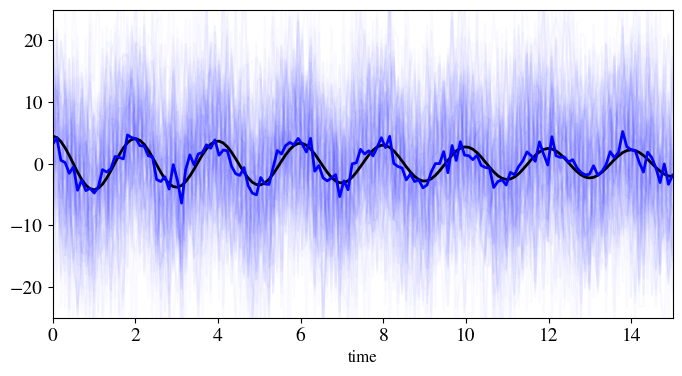

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))

M = np.sqrt(eta * gamma)

for m in result.measurement:
    ax.plot(times, m[:, 0].real / M, "b", alpha=0.025)

ax.plot(times, result_ref.expect[1], "k", lw=2)

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel("time", fontsize=12)
ax.plot(times,
        np.array(result.measurement).mean(axis=0)[:, 0].real / M, "b", lw=2);

### Form 2: Combined homodyne with deterministic dissipation for missed detection events

$\displaystyle D_{1}[A]\rho(t) = \mathcal{D}[\kappa a]\rho(t) = \mathcal{D}[A]\rho(t)$

In [19]:
L = liouvillian(H, np.sqrt(gamma) * a)


def d1_rho_func(t, rho_vec):
    return L * rho_vec

$\displaystyle D_{2}[A]\rho(t) = \sqrt{\eta} \mathcal{H}[\sqrt{\kappa} a]\rho(t) = \sqrt{\eta} \mathcal{H}[A]\rho(t) 
= \sqrt{\eta}(A\rho + \rho A^\dagger - \mathrm{Tr}[A\rho + \rho A^\dagger] \rho)
\rightarrow \sqrt{\eta} \left((A_L +  A_R^\dagger)\rho_v - \mathrm{Tr}[(A_L +  A_R^\dagger)\rho_v] \rho_v\right)$

In [20]:
n_sum = spre(np.sqrt(gamma) * a) + spost(np.sqrt(gamma) * a.dag())


def d2_rho_func(t, rho_vec):
    e1 = expect_rho_vec(n_sum.data, rho_vec, False)
    return np.vstack([np.sqrt(eta) * (n_sum * rho_vec - e1 * rho_vec)])

In [21]:
result_ref = mesolve(H, rho0, times, c_ops + sc_ops, e_ops)

In [22]:
result = general_stochastic(
    ket2dm(rho0),
    times,
    e_ops=[spre(op) for op in e_ops],
    ntraj=75,
    nsubsteps=100,
    solver="platen",
    d1=d1_rho_func,
    d2=d2_rho_func,
    len_d2=1,
    m_ops=[spre(a + a.dag())],
    dW_factors=[1 / np.sqrt(gamma * eta)],
    store_measurement=True,
    map_func=parallel_map,
    noise=111,
)

10.7%. Run time:   3.77s. Est. time left: 00:00:00:31


20.0%. Run time:   7.50s. Est. time left: 00:00:00:29


30.7%. Run time:  11.27s. Est. time left: 00:00:00:25


40.0%. Run time:  14.88s. Est. time left: 00:00:00:22


50.7%. Run time:  18.61s. Est. time left: 00:00:00:18


60.0%. Run time:  22.29s. Est. time left: 00:00:00:14


70.7%. Run time:  25.99s. Est. time left: 00:00:00:10


80.0%. Run time:  28.24s. Est. time left: 00:00:00:07


90.7%. Run time:  32.02s. Est. time left: 00:00:00:03


100.0%. Run time:  35.16s. Est. time left: 00:00:00:00


Total run time:  35.17s


(<Figure size 800x400 with 2 Axes>,
 array([[<AxesSubplot:>],
        [<AxesSubplot:xlabel='time'>]], dtype=object))

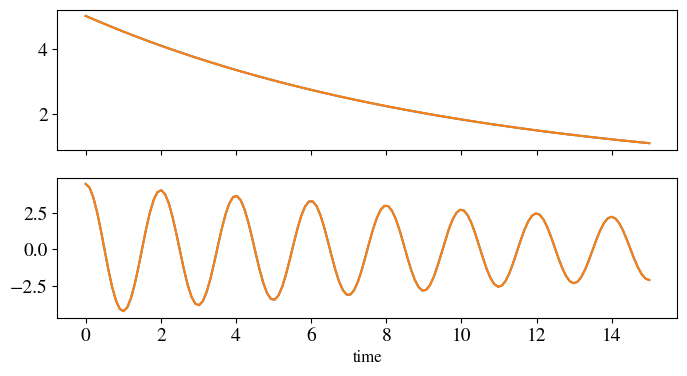

In [23]:
plot_expectation_values([result, result_ref])

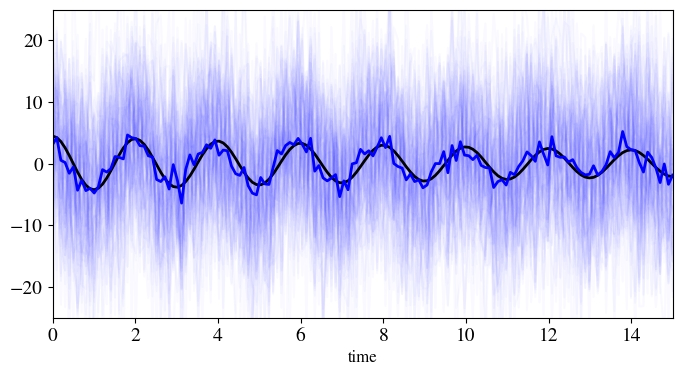

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))

for m in result.measurement:
    ax.plot(times, m[:, 0].real, "b", alpha=0.025)

ax.plot(times, result_ref.expect[1], "k", lw=2)

ax.set_ylim(-25, 25)
ax.set_xlim(0, times.max())
ax.set_xlabel("time", fontsize=12)
ax.plot(times, np.array(result.measurement).mean(axis=0)[:, 0].real, "b", lw=2);

## Versions

In [25]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.6
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     0.29.37
Matplotlib Version: 3.5.2
Python Version:     3.10.4
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v4/lib/python3.10/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer